# Lecture 6 - Intorduction to diffusion

*Disclaimer*: This lecture is heavily guided by the contents of the Tiny-diffusion GitHub at https://github.com/tanelp/tiny-diffusion/tree/master

**Dependencies**

In [1]:
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 23.2 MB/s eta 0:00:00


Load your drive using this (if necessary):

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Set up dependencies of the notebook

In [21]:
import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset

import pytorch_lightning as pl
import torchmetrics
from pytorch_lightning import seed_everything

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

# Diffusion - Small introduction

In this **notebook**, we are implementing a very limited **Diffusion** model to transform random noise points into interesting shapes. Diffusion models have two different workflows, one for training and the other for inference (or generation). First, the training process of diffusion models try to estimate the amount of noise a data distribution. Let $𝛜_θ(x, t)$ be the model with $θ$ parametrization (learnable weights) which receives a noisy image and the nummber of timesteps it has been through the noising process. This expression aims to approximate $𝛜 ∼ 𝒩(0, I)$ where $𝛜$ is noise sampled from a normal distribution with 0 average and 1 deviation.

This learning objective lets $𝛜_θ(x, t)$ detect the 'amount of noise' contained in a data distribution, and therefore, after estimating the noise in this data distribution, we can *remove* it. This process is the inference, also called denoising. In essence, we want to remove noise from $x_t$, reducing the timesteps of noise using an expression similar to $x_{t-1} = x_t - 𝛜_θ(x_t, t)$.

So, in this notebook we will adress this entire training process for a minimal dataset.

This notebook is divided into the following sections:


*   Data Loading
*   Model definition
*   Training




## Data Loading
The data loading requires downloading the data from kaggle at kaggle: [filebb/datasaurus](**Data**:
https://www.kaggle.com/datasets/filebb/datasaurus
)

This dataset contains pairs of points that, when plotted, form a dinosaur head. There's not much more to it, but we want to train a model that, given random noise, it can replicate these dinosaur heads by way of denoise it.

There's not much preprocessing involved but some random noise will help the model build dinosaurs.

Example of the process

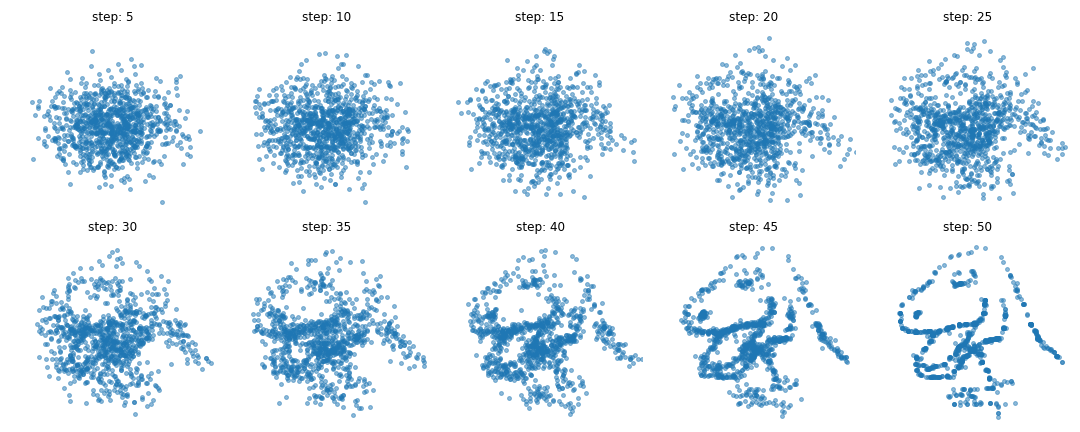

In [3]:
DATA_PATH = 'datasauRus.csv'
SEED = 42
seed_everything(seed=SEED) # Set seed for reproducibility,

INFO:lightning_fabric.utilities.seed:Seed set to 42


42

In [11]:
df = pd.read_csv(DATA_PATH)
df = df[df["dataset"] == "dino"]
df

,dataset,x,y
0,dino,55.3846,97.1795
1,dino,51.5385,96.0256
2,dino,46.1538,94.4872
3,dino,42.8205,91.4103
4,dino,40.7692,88.3333
...,...,...,...
137,dino,39.4872,25.3846
138,dino,91.2821,41.5385
139,dino,50.0000,95.7692
140,dino,47.9487,95.0000


This is what the data points look like!

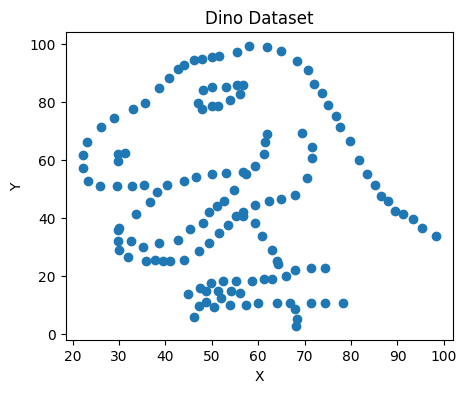

In [13]:
plt.figure(figsize=(5, 4))
plt.scatter(df['x'], df['y'])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Dino Dataset')
plt.show()

Now, we build the dataset using some extra random noise to make the dinosaur have more points!


In [126]:
class DinoModule(pl.LightningDataModule):
    def __init__(self, path, batch_size=16, n=8000):
        super().__init__()
        self.batch_size = batch_size
        self.full_len = len(df)
        self.path = path
        self.n = n

    def setup(self, stage=None):
        # We can't perform numerical evaluations! Only train + val
        df = pd.read_csv(self.path)
        df = df[df["dataset"] == "dino"]

        rng = np.random.default_rng(42)
        ix = rng.integers(0, len(df), self.n)
        x = df["x"].iloc[ix].tolist()
        x = np.array(x) + rng.normal(size=len(x)) * 0.15
        y = df["y"].iloc[ix].tolist()
        y = np.array(y) + rng.normal(size=len(x)) * 0.15
        x = (x/54 - 1) * 4
        y = (y/48 - 1) * 4
        X = np.stack((x, y), axis=1)

        self.train_data = TensorDataset(torch.from_numpy(X.astype(np.float32)))

    def collate_fn(self, batch):
        batch = list(zip(*batch))[0]
        return torch.stack(batch, axis=0) # [batch_size, 2]

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_data,
                                           batch_size=self.batch_size,
                                           shuffle=True,
                                           collate_fn=self.collate_fn,
                                           drop_last=True,)

## Diffusion

We are implementing diffusion using the method described in DDPM (https://arxiv.org/abs/2006.11239). First we begin with a simplistic MLP model, designed to denoise. This has 2 components, the `SinusoidalEmbedding` and the `Block`.

First, `SinusoidalEmbedding` are positional embeddings.

In [127]:
class SinusoidalEmbedding(nn.Module):
    def __init__(self, size, scale = 1.0):
        super().__init__()
        self.size = size
        self.scale = scale
        self.const = torch.Tensor([10000.0])

    def forward(self, x):
        x = x * self.scale
        half_size = self.size // 2
        emb = torch.log(self.const) / (half_size - 1)
        emb = torch.exp(-emb * torch.arange(half_size))
        emb = x.unsqueeze(-1) * emb.unsqueeze(0)
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
        return emb

    def __len__(self):
        return self.size

Second `Block` is a simple Linear + Activation layer.

In [128]:
class Block(nn.Module):
    def __init__(self, size):
        super().__init__()

        self.ff = nn.Linear(size, size)
        self.act = nn.GELU()

    def forward(self, x):
        return x + self.act(self.ff(x))

The final module `MLP` puts everything together. The architecture has two embeddings, one for each coordinate of the dataset and a final embedding for the ime dimension.

In [129]:
class MLP(nn.Module):
    def __init__(self, hidden_size = 128, hidden_layers = 3,
                 emb_size = 128):
        super().__init__()

        self.time_mlp = SinusoidalEmbedding(emb_size)
        self.input_mlp1 = SinusoidalEmbedding(emb_size, scale=25.0)
        self.input_mlp2 = SinusoidalEmbedding(emb_size, scale=25.0)

        concat_size = len(self.time_mlp) + \
            len(self.input_mlp1) + len(self.input_mlp2)
        layers = [nn.Linear(concat_size, hidden_size), nn.GELU()]
        for _ in range(hidden_layers):
            layers.append(Block(hidden_size))
        layers.append(nn.Linear(hidden_size, 2))
        self.joint_mlp = nn.Sequential(*layers)

    def forward(self, x, t):
        x1_emb = self.input_mlp1(x[:, 0])
        x2_emb = self.input_mlp2(x[:, 1])
        t_emb = self.time_mlp(t)
        x = torch.cat((x1_emb, x2_emb, t_emb), dim=-1)
        x = self.joint_mlp(x)
        return x

## Scheduler
Now we are going to define the core of the diffusion model. The MLP was fairly simple, and is the parametrization of $𝛜_θ(x, t)$. Now we have to define the entire scheduler to train. This requires several parts to make everything fit neatly together going forward.

Let's begin with some definitions, we need to dephine the betas. For our examples, the betas will take the following shape:

$$β_{start} = 0.0001$$
$$β_{end} = 0.02$$
$$β = [0.0001, ..., 0.02]$$

The betas here denote the variance schedule.

In [130]:
beta_start = 0.0001
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, 1000) #Linear scheduling
# Default to 1000 timesteps maximum

Now we describe the alphas. Remember, later we will compute a noisy example as:

$\sqrt{\hat{α_t}}x_0 + \sqrt{1-\hat{α_t}}𝛜$

Therefore we want to compute the alphas, which come defined by $α_t = 1 - β_t$, similarly we compute the hat alpha with $\hat{α_t} = ∏^t_{s=1}α_s$

In [131]:
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.)
alphas[:25]

tensor([0.9999, 0.9999, 0.9999, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998, 0.9997,
        0.9997, 0.9997, 0.9997, 0.9997, 0.9996, 0.9996, 0.9996, 0.9996, 0.9996,
        0.9995, 0.9995, 0.9995, 0.9995, 0.9995, 0.9994, 0.9994])

Furthermore, there are some frequently computed operations later. First the operations required for adding noise:
- $\sqrt{\hat{α_t}}$
- $\sqrt{1-\hat{α_t}}$

These are used in the denoising:
- $\frac{1}{\sqrt{\hat{α_t}}}$
- $\frac{1}{\sqrt{\hat{α_t}-1}}$



So it will be efficient to pre-compute them.

In [132]:
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
sqrt_inv_alphas_cumprod = torch.sqrt(1. / alphas_cumprod)
sqrt_inv_alphas_cumprod_minus_one = torch.sqrt(1. / alphas_cumprod - 1)

Finally, we need two more coefficients:
$$a_t = \frac{β_t \sqrt{\hat{α}_{t-1}}}{1 - \hat{α_t}}$$
$$b_t = \frac{(1-\hat{α}_{t-1})\sqrt{α_t}}{1 - \hat{α_t}}$$

to later compute:

$$\hat{μ}(x_t, x_0) = a_tx_0 + b_tx_t$$

Which is used for denoising.


In [133]:
posterior_mean_coef1 = betas * torch.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod)
posterior_mean_coef2 = (1. - alphas_cumprod_prev) * torch.sqrt(alphas) / (1. - alphas_cumprod)

First, lets define the basic process of noise addition. This is given by the expression:

$$\sqrt{\hat{α_t}}x_0 + \sqrt{1-\hat{α_t}}𝛜$$

where $x_0$ is the noiseless image and $𝛜$ is drawn from a random normal distribution.

In [134]:
def add_noise(x_0, eps, timesteps):
  s1 = sqrt_alphas_cumprod[timesteps].reshape(-1, 1) #Reshape to handle batches
  s2 = sqrt_one_minus_alphas_cumprod[timesteps].reshape(-1, 1)
  return s1 * x_0 + s2 * eps

That's all for training!

Now for the hard part, the denoising auxiliary funcions. The denoising process requires to follow:

$$x_{t-1} = \hat{μ}(x_t, \hat{x_0}) + σ_tz$$

where $\sigma_t$ is the variance at timestep $t$ and $z$ is another noise vector. We begin defining how to get the variance.



In [135]:
def get_variance(t):
  if t==0:
    return 0

  variance = betas[t] * (1 - alphas_cumprod[t-1]) / (1 - alphas_cumprod[t])
  variance = variance.clip(1e-20)
  return variance

Next, we continue defining the left part of the equation by defining $\hat{x_0}$ as:

$$\hat{x_0} = \frac{1}{\hat{α}}x_t + \frac{1}{\sqrt{\hat{α_t}-1}} 𝛜_θ(x_t, t)$$

This is an estimated reconstruction of the original inputs ($x_0$)

In [136]:
def reconstruct_x0(x_t, t, noise):
  s1 = sqrt_inv_alphas_cumprod[t].reshape(-1, 1)
  s2 = sqrt_inv_alphas_cumprod_minus_one[t].reshape(-1, 1)
  return s1 * x_t + s2 * noise

Again, we compute the output as: $$\hat{μ}(x_t, x_0) = a_tx_0 + b_tx_t$$

In [137]:
def q_posterior(x_0, x_t, t):
  s1 = posterior_mean_coef1[t].reshape(-1, 1)
  s2 = posterior_mean_coef2[t].reshape(-1, 1)
  return s1 * x_0 + s2 * x_t # mu

All together, finally:

In [138]:
def step(model_output, timestep, sample):
  t = timestep
  pred_original_sample = reconstruct_x0(sample, t, model_output)
  pred_sample = q_posterior(pred_original_sample, sample, t)

  variance = 0

  if t > 0:
    noise = torch.randn_like(model_output)
    variance = (get_variance(t) ** 0.5) * noise

  pred_sample = pred_sample + variance

  return pred_sample

### Scheduler Module
Instead of intermediate code, we build the entire scheduler as a single module.

In [139]:
class NoiseScheduler():
    def __init__(self,
                 num_timesteps=1000,
                 beta_start=0.0001,
                 beta_end=0.02,
                 ):

        self.num_timesteps = num_timesteps
        self.betas = torch.linspace(
                beta_start, beta_end, num_timesteps, dtype=torch.float32)

        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(
            self.alphas_cumprod[:-1], (1, 0), value=1.)

        # required for self.add_noise
        self.sqrt_alphas_cumprod = self.alphas_cumprod ** 0.5
        self.sqrt_one_minus_alphas_cumprod = (1 - self.alphas_cumprod) ** 0.5

        # required for reconstruct_x0
        self.sqrt_inv_alphas_cumprod = torch.sqrt(1 / self.alphas_cumprod)
        self.sqrt_inv_alphas_cumprod_minus_one = torch.sqrt(
            1 / self.alphas_cumprod - 1)

        # required for q_posterior
        self.posterior_mean_coef1 = self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)
        self.posterior_mean_coef2 = (1. - self.alphas_cumprod_prev) * torch.sqrt(self.alphas) / (1. - self.alphas_cumprod)

    def reconstruct_x0(self, x_t, t, noise):
        s1 = self.sqrt_inv_alphas_cumprod[t].reshape(-1, 1)
        s2 = self.sqrt_inv_alphas_cumprod_minus_one[t].reshape(-1, 1)
        return s1 * x_t - s2 * noise

    def q_posterior(self, x_0, x_t, t):
        s1 = self.posterior_mean_coef1[t].reshape(-1, 1)
        s2 = self.posterior_mean_coef2[t].reshape(-1, 1)
        mu = s1 * x_0 + s2 * x_t
        return mu

    def get_variance(self, t):
        if t == 0:
            return 0

        variance = self.betas[t] * (1. - self.alphas_cumprod_prev[t]) / (1. - self.alphas_cumprod[t])
        variance = variance.clip(1e-20)
        return variance

    def step(self, model_output, timestep, sample):
        t = timestep
        pred_original_sample = self.reconstruct_x0(sample, t, model_output)
        pred_prev_sample = self.q_posterior(pred_original_sample, sample, t)

        variance = 0
        if t > 0:
            noise = torch.randn_like(model_output)
            variance = (self.get_variance(t) ** 0.5) * noise

        pred_prev_sample = pred_prev_sample + variance

        return pred_prev_sample

    def add_noise(self, x_start, x_noise, timesteps):
        s1 = self.sqrt_alphas_cumprod[timesteps].reshape(-1, 1)
        s2 = self.sqrt_one_minus_alphas_cumprod[timesteps].reshape(-1, 1)
        return s1 * x_start + s2 * x_noise

    def __len__(self):
        return self.num_timesteps

## Training

So, to train we need to set up the LightningModule as usual. Now we have to put the module together, including the model and scheduler.

In [143]:
class DinoDiffusion(pl.LightningModule):
    def __init__(self,
                 model, scheduler,
                 learning_rate=1e-3,
                 weight_decay=0.):
        super(DinoDiffusion,self).__init__()
        self.save_hyperparameters() # Save Hyperparams
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.model = model
        self.scheduler = scheduler
        self.criterion = nn.MSELoss()

    def forward(self, x, t):
        return self.model(x, t)

    def compute_batch(self, batch, split='train'):
        noise = torch.randn(batch.shape)
        timesteps = torch.randint(0, len(self.scheduler), (batch.shape[0],)).long()

        noisy = self.scheduler.add_noise(batch, noise, timesteps)
        output = self(noisy, timesteps)
        loss = self.criterion(output, noise)

        self.log_dict(
            {
                f'{split}_loss': loss,
            },
            on_epoch=True, prog_bar=True)

        return loss

    def training_step(self, batch, batch_idx):
        return self.compute_batch(batch, 'train')

    def predict_step(self, batch, batch_idx):
        return self(batch)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.learning_rate,
                                 weight_decay=self.weight_decay) # self.parameters() son los parámetros del modelo

In [165]:
#@title Hyper-parameters

LEARNING_RATE = 1e-3 #@param {type:"number"}
WEIGHT_DECAY = 0. #@param {type:"number"}
BATCH_SIZE = 32 # @param ["2","4","8","16","32"] {"type":"raw"}
MAX_EPOCHS = 25 # @param {"type":"slider","min":0,"max":100,"step":1}
HIDDEN_DIM = 64 # @param {"type":"slider","min":0,"max":128,"step":1}
TIMESTEPS = 25 # @param {"type":"slider","min":0,"max":128,"step":1}
SAVE_DIR = f'lightning_logs/dinos/{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}'


### Train loop

In [ ]:
# DataModule
data_module = DinoModule(DATA_PATH, batch_size=BATCH_SIZE)

# Model
model = MLP(emb_size=HIDDEN_DIM)

# Scheduler
scheduler = NoiseScheduler(TIMESTEPS)

# LightningModule
module = DinoDiffusion(model, scheduler,
                       learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Loggers
csv_logger = pl.loggers.CSVLogger(
    save_dir=SAVE_DIR,
    name='metrics',
    version=None
)

loggers = [csv_logger] # se pueden poner varios loggers (mirar documentación)

# Trainer
trainer = pl.Trainer(max_epochs=MAX_EPOCHS, accelerator='cpu',
                     logger=loggers,
                     gradient_clip_val=1)

trainer.fit(module, data_module)

### Visualization
The model has been trained, then lets denoise some random data.

In [ ]:
def generate_dino(sample_size=1000):
  random_sample = torch.randn(sample_size, 2)
  timesteps = list(range(len(module.scheduler)))[::-1]
  for i, t in enumerate(timesteps):
    t = torch.from_numpy(np.repeat(t, sample_size))
    with torch.no_grad():
      residual = module(random_sample, t)
    random_sample = module.scheduler.step(residual, t[0], random_sample)

  return random_sample.numpy()

In [ ]:
# Generate dino samples
generated_samples = generate_dino()

# Plot the generated dino
plt.figure(figsize=(5, 4))
plt.scatter(generated_samples[:, 0], generated_samples[:, 1])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Generated Dino Dataset')
plt.show()